# Getting started with DeBaCl

## 1. Unbalanced Moon

Our first step is to create some data using the scikit-learn `make_blobs` and `make_circles` utility. To make this a hard (but not impossible) clustering problem, we set the random state of the blob so that it's always outside the two concentric circles.

In [102]:
import numpy as np
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import csv
%matplotlib inline
X = np.genfromtxt('unbalanced_banana.csv', delimiter=',')
#X = np.genfromtxt('banana.csv', delimiter=',')
#X = np.genfromtxt('taerget_generated_data.csv', delimiter=',')
print "Dataset shape:", X.shape

Dataset shape: (1800L, 2L)


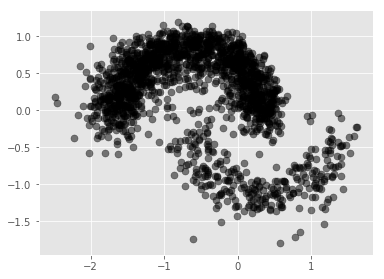

In [103]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(X[:, 0], X[:, 1], c='black', s=50, alpha=0.5)
    fig.show()

##  Estimate the level set tree

The Level Set Tree (LST) can be constructed directly from our tabular dataset. The most important choice is **the bandwidth parameter `k`, which controls the complexity** of the level set tree.

Small values of `k` allow for complex trees with many leaves, which can good for discovering small clusters, with the caveat that these clusters may not be true features of the underlying data-generating process. Large values of `k` lead to very simple trees with few branches, but these trees are likely to be very stable across repeated samples from the same probability distribution.

Choosing the bandwidth parameter in a principled way remains an open area of research, and a future tutorial will illustrate some helpful heuristics for finding a good value. For now, we use the value `k=20`, which was chosen through trial and error.

In [125]:
import debacl as dcl
tree = dcl.construct_tree(X, k=20)

#print tree

The summary of an LST is a table where each row corresponds to a cluster in the tree. Each cluster has an **ID number**, start and end **density levels**, start and end **mass levels**, a **parent** cluster, **child** clusters, and a list of the data points that belong to the cluster, represented in the table by the **size** of this list.

The LST is constructed by finding connected components at successively higher levels in the estimated probability density function. Think of the density function as the water level rising around a set of islands representing the data points. When there is no water, all of the land masses are connected; as the water rises, land masses split into islands and vanish when the water gets high enough.

The **start density level** is the density value where a cluster first appears by splitting from its parent cluster. The **end density level** is the density value where the cluster disappears, either by splitting into child clusters or by vanishing when all of its points have insufficiently high density.

At each of the start and end density levels, a certain fraction of the points have been removed to create the *upper level sets* of the density function; these fractions are the **start and end mass levels**, respectively.

## Get clusters from the tree

In [124]:
#cluster_labels = pruned_tree.get_clusters()
#cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=2 )
cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=2 )
X_foreground = X[(cluster_labels[:,1] != -1),:]
y_foreground = cluster_labels[(cluster_labels[:,1] != -1),:]
X_background = X[(cluster_labels[:,1] == -1),:]
#use knn to classify background pts
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_foreground, y_foreground)
y_background = knn.predict(X_background)
cluster_labels[(cluster_labels[:,1] == -1),:] = y_background

There are many ways to use the LST to assign data points to clusters. **The default method** of the `get_clusters` method is to **return the points in the leaves** of the tree, which are the highest-density modal regions of the dataset. The big advantage of this method is that the user doesn't need to know the right number of clusters beforehand, or even to choose a single density level.

All clustering methods return a numpy matrix with two columns. The first column contains indices of data points and the second contains the integer label of a given point's cluster.

In general, the clusters obtained from the LST **exclude low-density data points** (the specific pattern of which points to exclude depends on the clustering strategy). In our example above, the cluster labels include only 493 of the original 600 data points.

## Plot the clusters in feature space 

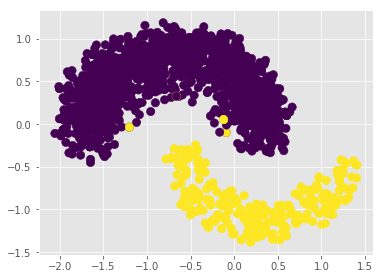

In [123]:
upper_level_idx = cluster_labels[:, 0]
upper_level_set = X[upper_level_idx, :]

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(upper_level_set[:, 0], upper_level_set[:, 1],
               c=cluster_labels[:, 1], s=70)
    fig.show()

## 2. Balanced Moon

In [ ]:
X = np.genfromtxt('banana.csv', delimiter=',')
tree = dcl.construct_tree(X, k=20)
cluster_labels = tree.get_clusters(method='first-k',fill_background=True, k=2 )
X_foreground = X[(cluster_labels[:,1] != -1),:]
y_foreground = cluster_labels[(cluster_labels[:,1] != -1),:]
X_background = X[(cluster_labels[:,1] == -1),:]
#use knn to classify background pts
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_foreground, y_foreground)
y_background = knn.predict(X_background)
cluster_labels[(cluster_labels[:,1] == -1),:] = y_background
upper_level_idx = cluster_labels[:, 0]
upper_level_set = X[upper_level_idx, :]

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.scatter(upper_level_set[:, 0], upper_level_set[:, 1],
               c=cluster_labels[:, 1], s=70)
    fig.show()

## 3. Target